## MedImageParse: A Unified Model for Biomedical Image Analysis

## Introduction


Biomedical image analysis plays a critical role in advancing scientific discoveries across multiple fields, such as **cell biology, pathology, radiology**, and more. However, extracting meaningful insights from medical images presents challenges, especially in tasks such as:

- **Segmentation:** Precisely outlining organs, abnormalities, and cells.
- **Detection:** Identifying specific structures like tumors or anomalies.
- **Recognition:** Assigning semantic labels to detected objects for further analysis.

Traditionally, these tasks were treated separately. **MedImageParse** (formerly known as BiomedParse) changes this by unifying segmentation, detection, and recognition into a single model. This unlocks new opportunities for clinicians and researchers, enabling them to focus more on discovery and insights rather than technical complexities.

**MedImageParse** is a biomedical foundation model developed in collaboration with **Microsoft Research, Providence Genomics**, and the **Paul G. Allen School of Computer Science and Engineering** at the University of Washington. It is part of the **Microsoft healthcare AI models** initiative.


## Sections Overview
1. **How to Run from a Deployed Endpoint on Azure**
2. **Installation Requirements**
3. **Segmentation Examples**
4. **References**

# 1. Prerequisites

To run this notebook you will need a dataset and an endpoint. 

## Download data

Use the following command to download the dataset with samples into your working folder. Once you download, make sure the files are in the `examples` folder so that all paths in this sample work.

`azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/segmentation-examples/* ./examples`

## Deploy and configure an endpoint

To run **MedImageParse** from an Azure-deployed endpoint, you will need:

- **Endpoint URL**
- **API key**
- **Model deployment name**

Refer to the [MedImageParse deployment notebook](https://aka.ms/healthcare-ai-examples-mip-deploy) and the documentation pages for endpoint deployment instructions. 

Refer to the following code cells for examples of how to set up and perform inference using the **AzureML SDK v2**. Note that authentication method demonstrated here is using basic authentication via the API key and is different from the one we have shown in the "deploy" notebook. We include this method to demonstrate a variety of ways in which you can invoke a deployed endpoint.

## **Set Endpoint Configuration**

Use the following code to set your endpoint configuration. Be sure to replace placeholders with your actual endpoint and API key.

In [1]:
endpoint_url = "https://christava-1459-lgmys.eastus.inference.ml.azure.com/score"  # Replace with your endpoint URL (without the route, e.g. https://<endpoint-name>.<location>.inference.ml.azure.com/)
api_key = "RzZKCWHe4w1RQ4gZKh7v1x1uKtnx7EcX"  # keys can be obtained from the "Consume" tab of the endpoint
azureml_model_deployment = None  # (optional) Replace with your model deployment name

inference_config = {
    "endpoint": endpoint_url,
    "api_key": api_key,
    "azureml_model_deployment": azureml_model_deployment,
}

Let’s verify the status and configuration of the endpoint to ensure it is ready for use. If the endpoint is not available or returns an error, please refer to the deployment demo for troubleshooting steps.

In [2]:
import urllib.request

url = f"{inference_config['endpoint']}/swagger.json"
req = urllib.request.Request(url)
req.add_header("Authorization", ("Bearer " + inference_config["api_key"]))
if inference_config["azureml_model_deployment"] is not None:
    req.add_header(
        "azureml-model-deployment", inference_config["azureml_model_deployment"]
    )

try:
    response = urllib.request.urlopen(req)
    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", "ignore"))

b'{"swagger": "2.0", "info": {"title": "ML service", "description": "API specification for the Azure Machine Learning service ML service", "version": "1.0"}, "schemes": ["https"], "consumes": ["application/json"], "produces": ["application/json"], "securityDefinitions": {"Bearer": {"type": "apiKey", "name": "Authorization", "in": "header", "description": "For example: Bearer abc123"}}, "paths": {"/": {"get": {"operationId": "ServiceHealthCheck", "description": "Simple health check endpoint to ensure the service is up at any given point.", "responses": {"200": {"description": "If service is up and running, this response will be returned with the content \'Healthy\'", "schema": {"type": "string"}, "examples": {"application/json": "Healthy"}}, "default": {"description": "The service failed to execute due to an error.", "schema": {"$ref": "#/definitions/ErrorResponse"}}}}}, "/score": {"post": {"operationId": "RunMLService", "description": "Run web service\'s model and get the prediction ou

# 2. Dependency installation
Make sure you have all necessary dependencies installed. To install the required packages, run the following command:

```bash
pip install -r requirements.txt

In [3]:
# Load the required libraries
from processing_utils import run_inference

# 3. Segmentation Examples
Below are several examples illustrating MedImageParse's prompt-based approach to segmentation. These examples demonstrate its capability to accurately segment various biomedical structures across different imaging modalities.

## 3.1 Lung Nodule Segmentation from Radiological Chest CT DICOM Files

This example demonstrates a prompt to create a single segmentation mask from a single CT slice. Note that we configure our image pre-processing code to apply "lung" window to the image before sending it to the model, for better localization. Note that the model effectively performs detection task alongside a segmentation task.

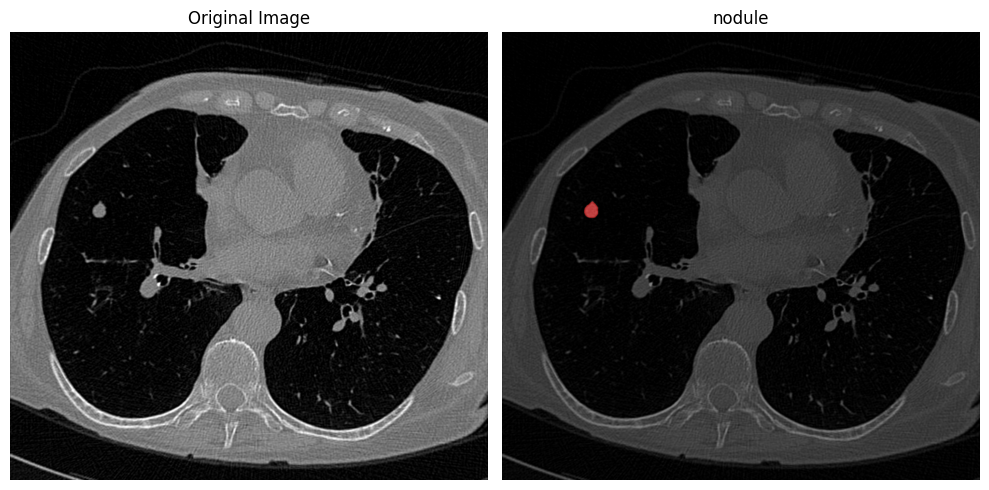

Output text features:  ['other lesion']
Array shape:  (1, 1024, 1024)


In [4]:
image_path = "./examples/CT_lung_nodule.dcm"
text_prompt = "nodule"

image, masks, text_features = run_inference(
    inference_config, image_path, text_prompt, is_CT=True, site="lung"
)
# Print output type of masks
print("Output text features: ", text_features)
print("Array shape: ", masks.shape)

## 3.2 Neuroradiological Analysis of Tumor Core, Enhancing, and Non-Enhancing Tumors using MRI T1-Gad

This example demonstrates multiple prompts to segment parts of a glioblastoma, an aggressive form brain cancer from a brain MR scan obtained using a contrast injection technique to highlight active tumor and provide better differentiation of tissues. Note that we show a technique to parse a NIFTI file and extract a slice from before preparing an image to send to the MedImageParse model. The model returns three segmentation masks and we demonstrate a technique to parse and display them.

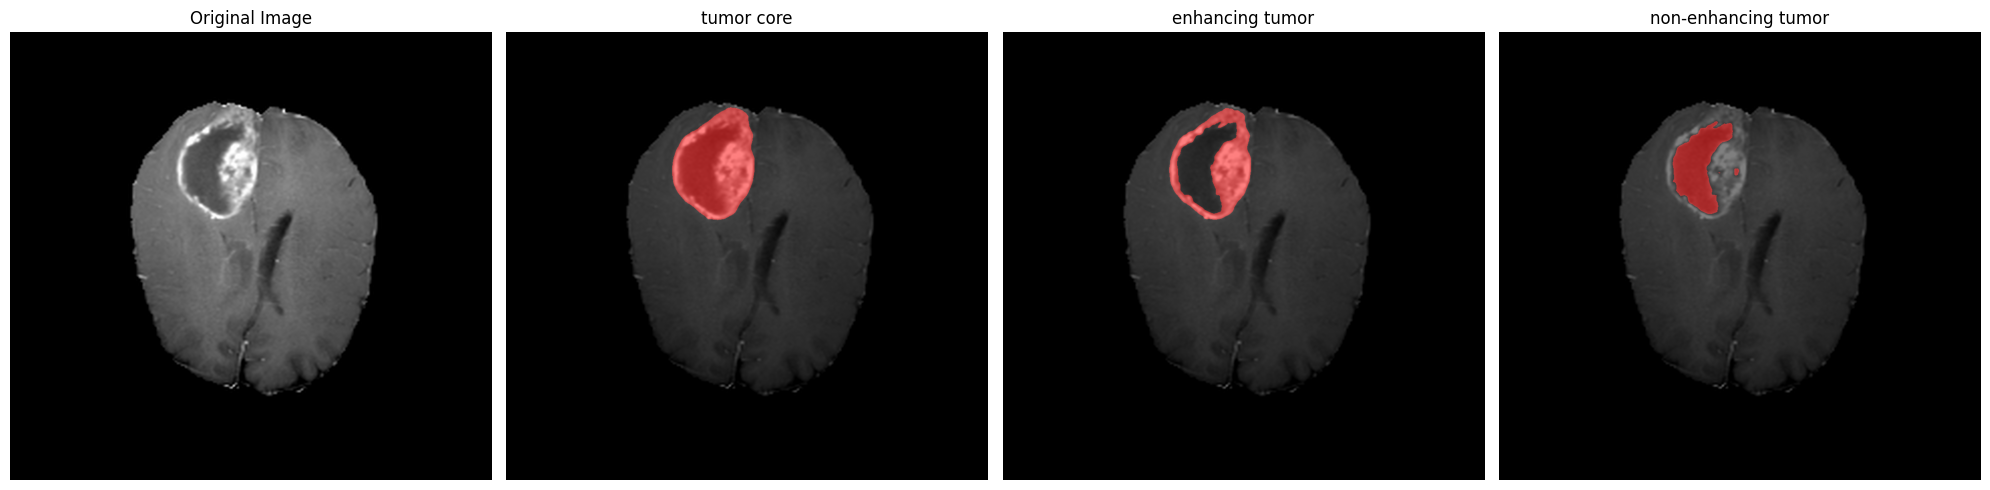

Output text features:  ['other', 'other', 'other']
Array shape:  (3, 1024, 1024)


In [5]:
image_path = "./examples/BRATS_397.nii.gz"
text_prompt = "tumor core & enhancing tumor & non-enhancing tumor"
slide_idx = 89

image, masks, text_features = run_inference(
    inference_config,
    image_path,
    text_prompt,
    is_CT=False,
    slice_idx=slide_idx,
    site=None,
    HW_index=(1, 0),
    channel_idx=2,
)
# Print output type of masks
print("Output text features: ", text_features)
print("Array shape: ", masks.shape)

## 3.3 Neuroradiological Analysis of Whole Tumor, Tumor Core, and Edema using MRI-FLAIR

This is an example similar to the previous one where we are asking the model to segment parts of a brain tumor on a different type of MRI scan called FLAIR (Fluid-Attenuated Inversion Recovery) which is a fluid-sensitive technique that can improve visibility of lesions alongside edema.

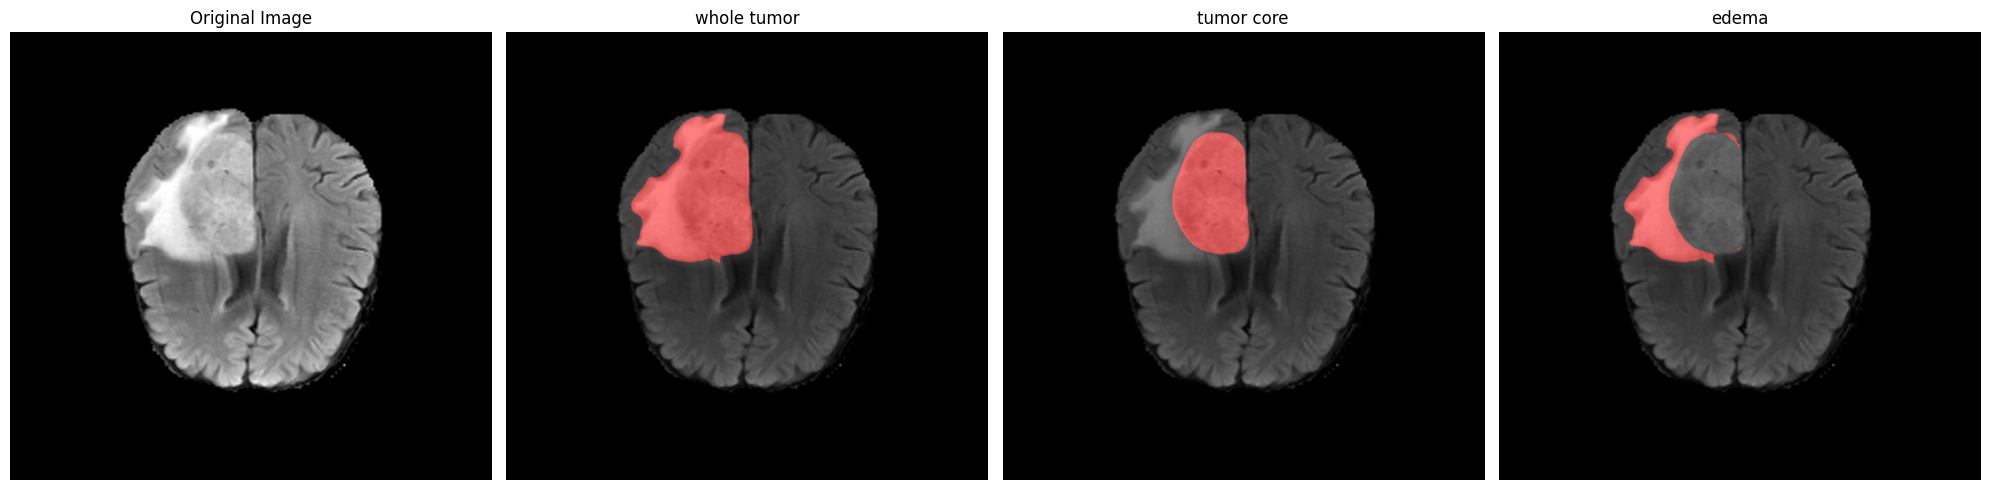

Output text features:  ['other', 'other', 'other']


In [6]:
image_path = "./examples/BRATS_422.nii.gz"
text_prompt = "whole tumor & tumor core & edema"
slide_idx = 84

image, masks, text_features = run_inference(
    inference_config,
    image_path,
    text_prompt,
    is_CT=False,
    slice_idx=slide_idx,
    HW_index=(1, 0),
    channel_idx=0,
)

print("Output text features: ", text_features)

## 3.4 Radiological Analysis of Kidney, Tumor, and Cyst using CT Imaging

This is another example that involves parsing a slice from a NIFTI file that contains an entire CT volume. In this example we are segmenting renal anatomy as well as both simple cysts (right side of image, left kidney) and renal malignancies (left side of image, right kidney).

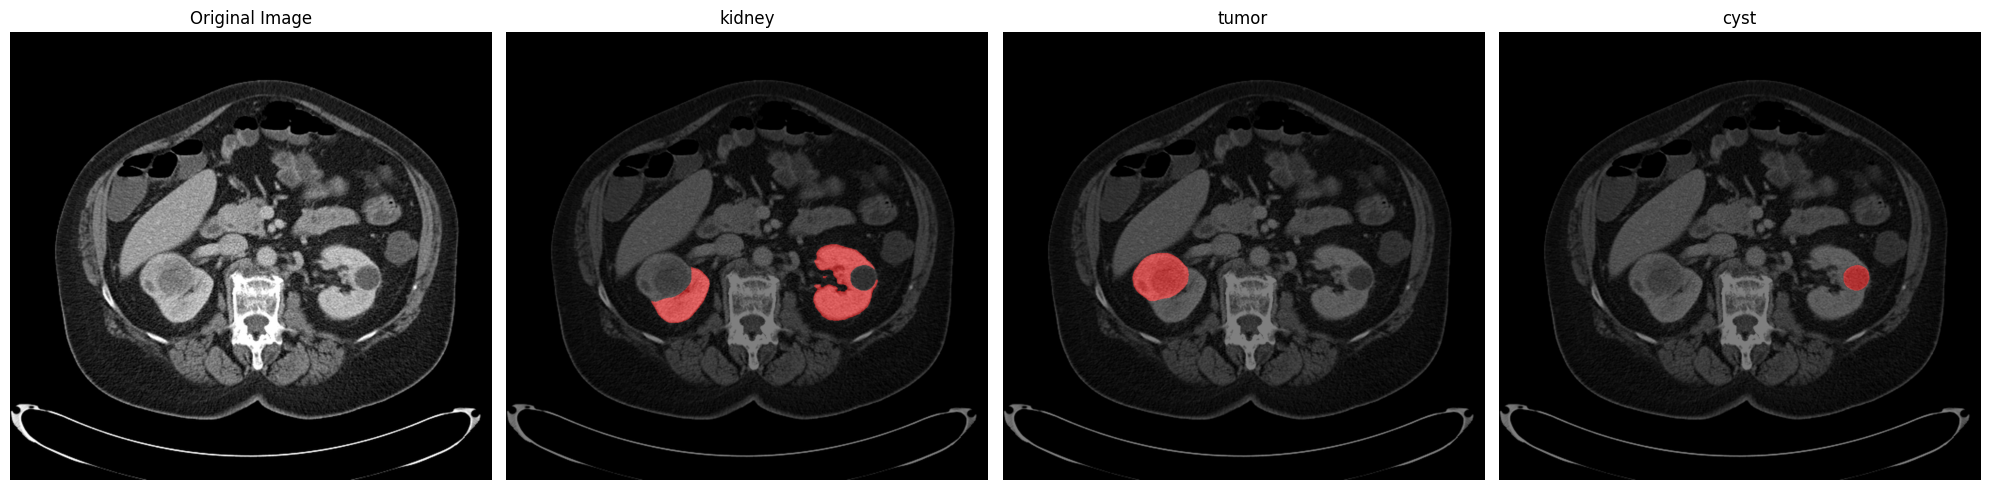

Output text features:  ['other', 'tumor', 'other']


In [7]:
image_path = "./examples/CT_kidney.nii.gz"
text_prompt = "kidney & tumor & cyst"
slide_idx = 32

image, masks, text_features = run_inference(
    inference_config,
    image_path,
    text_prompt,
    is_CT=True,
    slice_idx=slide_idx,
    site="abdomen",
    HW_index=(1, 2),
)

print("Output text features: ", text_features)

### 3.5 Echocardiographic Analysis of Left Ventricle and Left Atrium using Ultrasound Imaging

This example showcases the segmentation of a single frame from a sequence obtained using a different imaging modality - ultrasound. This type of imaging study is called an echocardiogram and it is used for study of cardiac function. In this example we are segmenting ventricular and atrial volumes from a transthoracic echocardiogram.

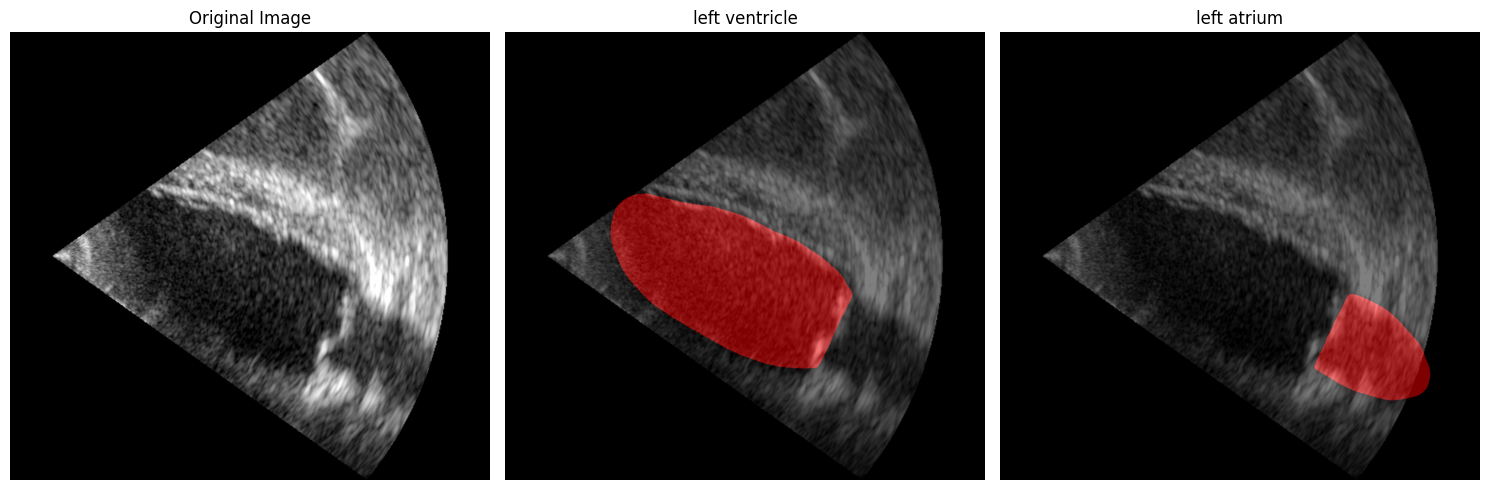

Text features:  ['other', 'other']
Array shape:  (2, 1024, 1024)


In [8]:
image_path = "./examples/patient0500_2CH_half_sequence.nii.gz"
text_prompt = "left ventricle & left atrium"
slide_idx = 0
image, masks, text_features = run_inference(
    inference_config,
    image_path,
    text_prompt,
    is_CT=False,
    slice_idx=slide_idx,
    site=None,
    HW_index=(0, 1),
)
# Print output type of masks
print("Text features: ", text_features)
print("Array shape: ", masks.shape)

## 3.6 Histopathological Analysis and Cell Phenotyping of Neoplastic, Inflammatory, and Connective Tissue Cells

In this example we are submitting a single image representing a portion of a digital pathology H&E slide.

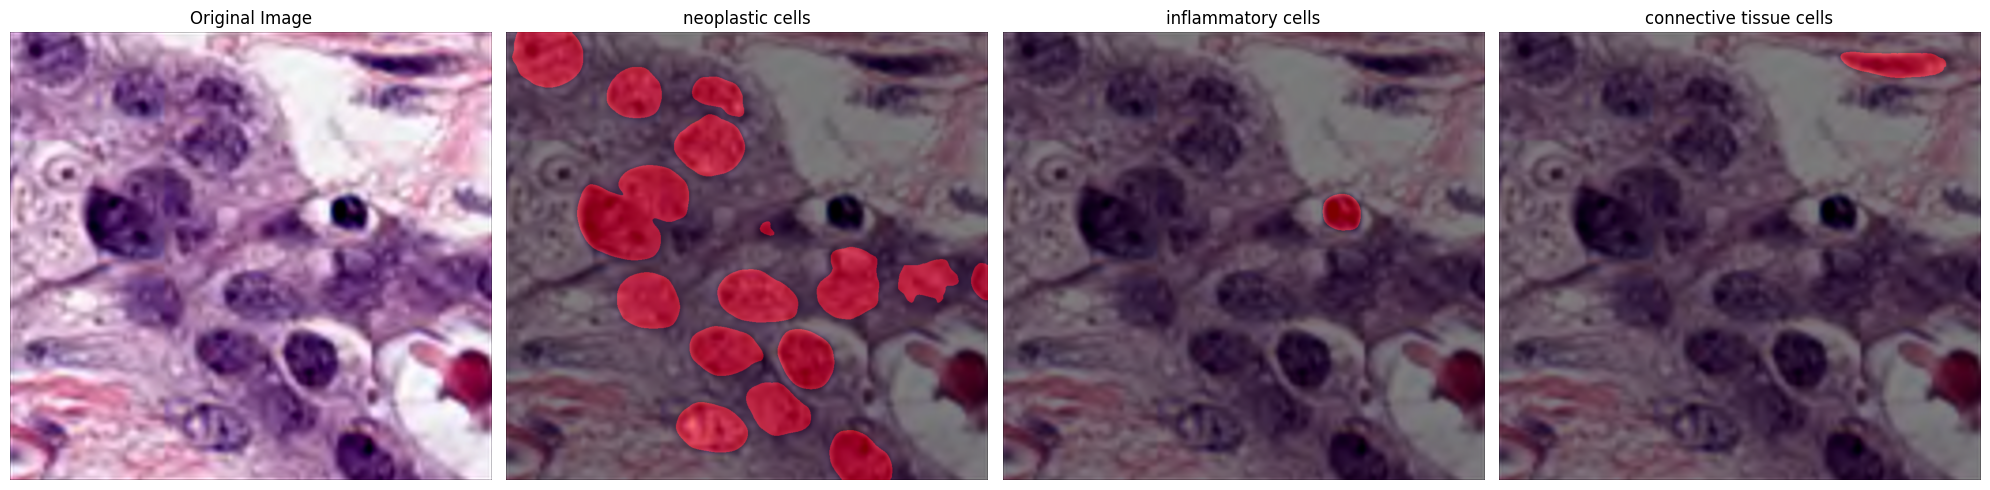

Text features:  ['other', 'other', 'other']


In [9]:
image_path = "./examples/pathology_breast_1.png"
text_prompt = "neoplastic cells & inflammatory cells & connective tissue cells"

image, masks, text_features = run_inference(inference_config, image_path, text_prompt)

print("Text features: ", text_features)

## 3.7 Perform Single Cell Analysis
The example below shows how to process MedImageParse output to visualize individual cells by appearance and classification using the output from the previous query.

MaskImageFilter (0x7ffdf8184c50): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffdf8184c50): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffdf8184c50): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 

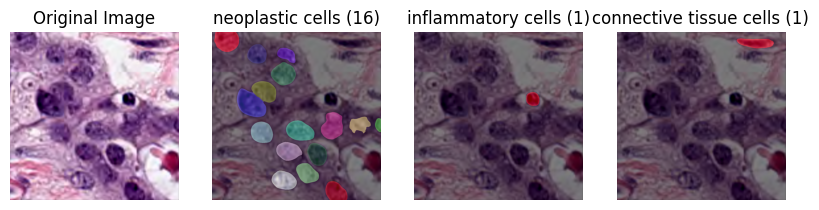

In [10]:
from processing_utils import plot_instance_segmentation_masks

plot_instance_segmentation_masks(image, masks, text_prompt)

## 3.8 Radiological Analysis of Left Lung, Right Lung, and COVID-19 Infection

The following example shows how the model can leverage its training data that contained a dataset of COVID patients to segment lung pathologies typical of a COVID infection

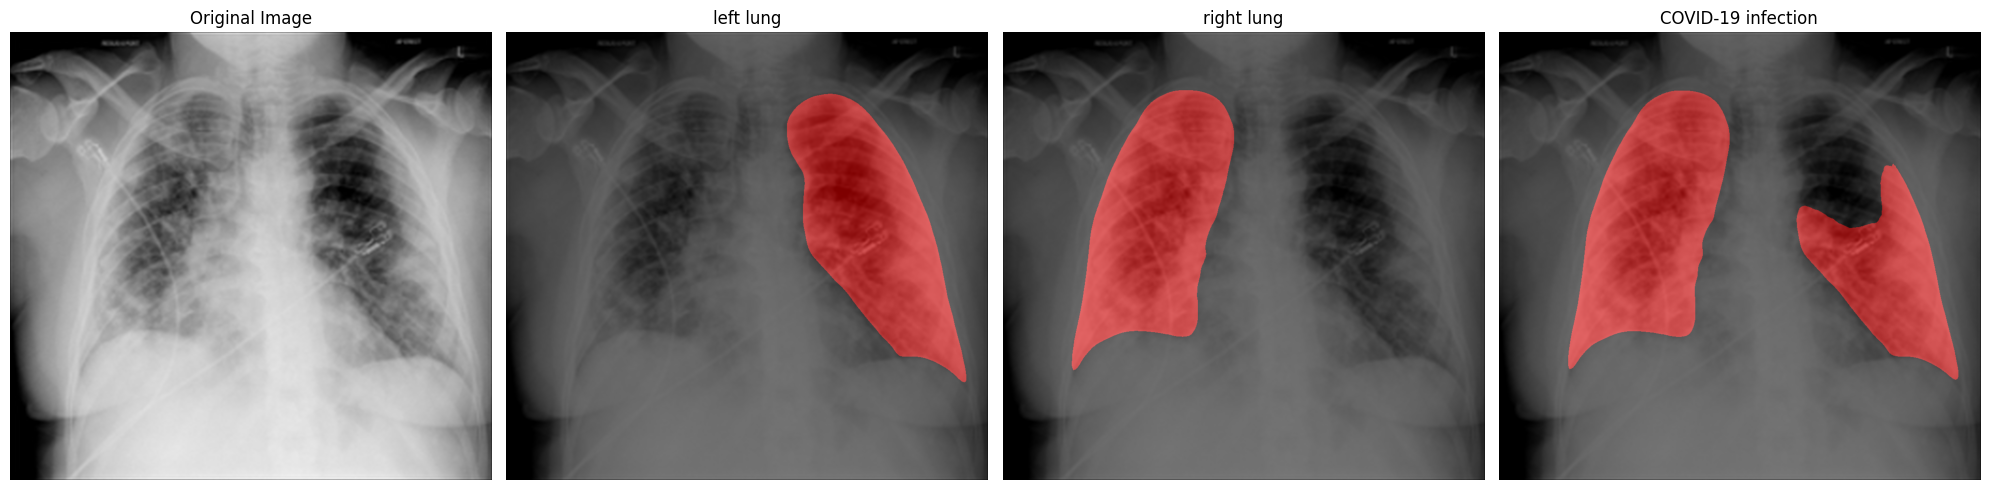

In [11]:
image_path = "./examples/covid_1585.png"
text_prompt = "left lung & right lung & COVID-19 infection"

image, masks, _ = run_inference(inference_config, image_path, text_prompt)

## 3.9 Ophthalmological Analysis of Optic Disc and Optic Cup

The image below is a photograph of a retina obtained using fundus camera. MedImageParse successfully segments portions of the anatomy in the image.

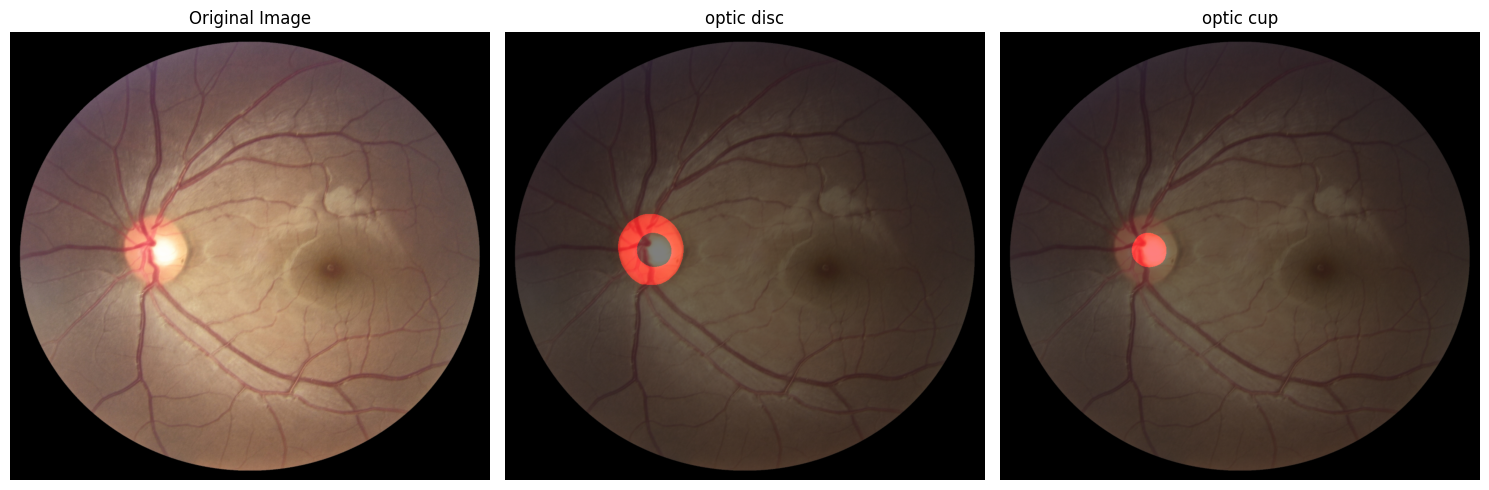

Text features:  ['other', 'eye anatomies']


In [12]:
image_path = "./examples/T0011.jpg"
text_prompt = "optic disc & optic cup"
image, masks, text_features = run_inference(inference_config, image_path, text_prompt)

print("Text features: ", text_features)

## 3.10 Endoscopic Analysis of Polyp

The image below is a frame from colonoscopy video with a large colon polyp.

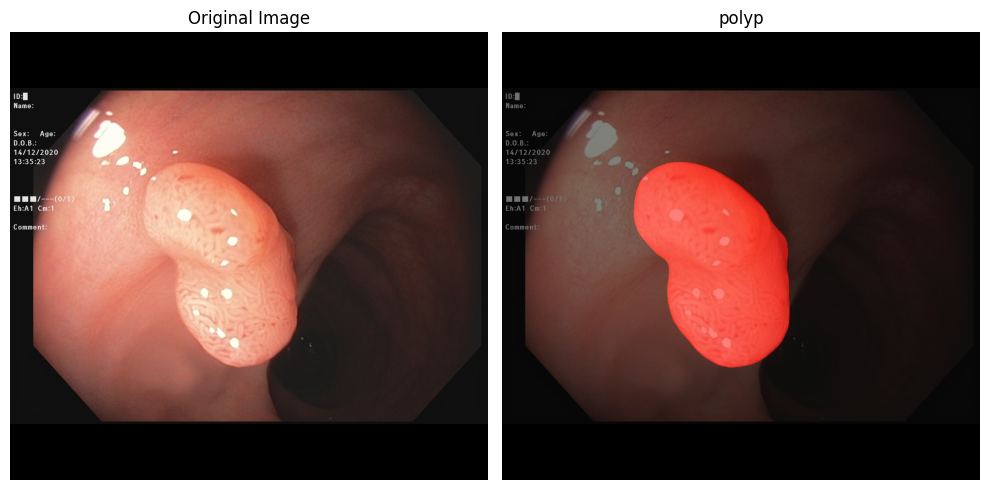

Text features:  ['other lesion']


In [13]:
image_path = "./examples/C3_EndoCV2021_00462.jpg"
text_prompt = "polyp"
image, masks, text_features = run_inference(inference_config, image_path, text_prompt)

print("Text features: ", text_features)

## 3.11 Dermatological Analysis of Skin Lesion

The image used in the following example is a high-resolution dermoscopic image that is resized to send it to MedImageParse model.

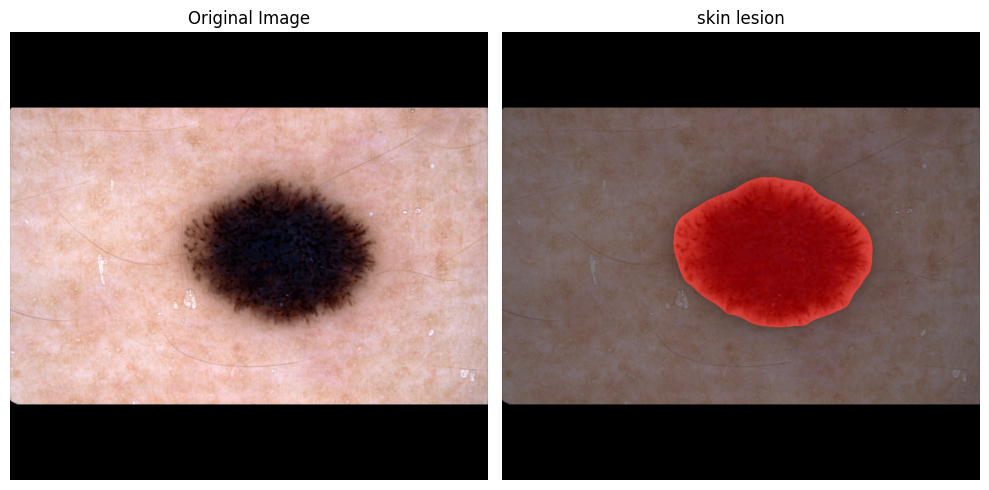

Text features:  ['other lesion']


In [14]:
image_path = "./examples/ISIC_0015551.jpg"
text_prompt = "skin lesion"
image, masks, text_features = run_inference(inference_config, image_path, text_prompt)

print("Text features: ", text_features)

## 3.12 Ophthalmological Analysis of Edema using OCT

The following image is a slice from an OCT scan, a type of eye exam used to evaluate the health of the retina. Note how MedImageParse is able to identify and segment a pathology in the scan.

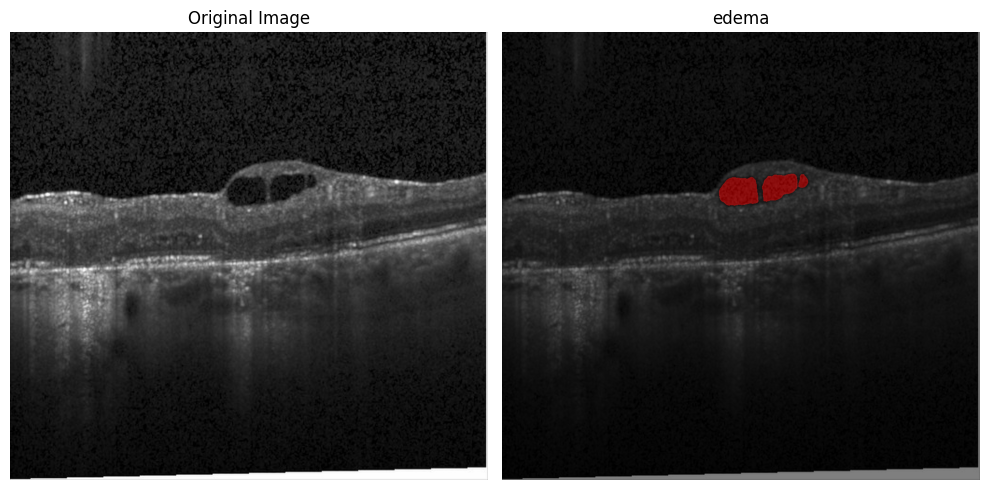

Text features:  ['fluid disturbance']


In [15]:
image_path = "./examples/144DME_as_F.jpeg"
text_prompt = "edema"
image, masks, text_features = run_inference(inference_config, image_path, text_prompt)

print("Text features: ", text_features)

# 4. References

For further details see:

 - [BiomedParse OSS Github project](https://microsoft.github.io/BiomedParse/)

 - [BiomedParse Paper](https://arxiv.org/abs/2405.12971)